# Cat vs. Dog Image Classification

# Import Libraries

In [ ]:
import os
import PIL
import glob
import shutil
import random
import pandas as pd
from PIL import Image
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, Add, MaxPooling2D, Dense, BatchNormalization, Dropout, Flatten

# Loading Data

In [ ]:
corrupted_images = []

def is_valid_image(image_path):
    try:
        img = Image.open(image_path)
        img.verify()
        return True
    except (IOError, SyntaxError, PIL.UnidentifiedImageError):
        print(f"Corrupted image: {image_path}")
        corrupted_images.append(image_path)
        return False

In [ ]:
import kagglehub
path = kagglehub.dataset_download("shaunthesheep/microsoft-catsvsdogs-dataset")

print("Path to dataset files:", path)

100%|██████████| 788M/788M [00:20<00:00, 40.9MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/shaunthesheep/microsoft-catsvsdogs-dataset/versions/1


In [ ]:
print("Path to dataset files:", path)
print("Contents of dataset directory:", os.listdir(path))

Path to dataset files: /root/.cache/kagglehub/datasets/shaunthesheep/microsoft-catsvsdogs-dataset/versions/1
Contents of dataset directory: ['readme[1].txt', 'MSR-LA - 3467.docx', 'PetImages']


In [5]:
data_dir = os.path.join(path, 'PetImages')

In [6]:
output_dir = '/content/data'

In [7]:
train_dir = os.path.join(output_dir, 'train')
val_dir = os.path.join(output_dir, 'val')
test_dir = os.path.join(output_dir, 'test')

In [8]:
for folder in [train_dir, val_dir, test_dir]:
    os.makedirs(os.path.join(folder, 'cats'), exist_ok=True)
    os.makedirs(os.path.join(folder, 'dogs'), exist_ok=True)

In [9]:
cat_images = glob.glob(os.path.join(data_dir, 'Cat', '*'))
dog_images = glob.glob(os.path.join(data_dir, 'Dog', '*'))

In [10]:
cat_images = [img for img in cat_images if is_valid_image(img)]
dog_images = [img for img in dog_images if is_valid_image(img)]

Corrupted image: /root/.cache/kagglehub/datasets/shaunthesheep/microsoft-catsvsdogs-dataset/versions/1/PetImages/Cat/666.jpg
Corrupted image: /root/.cache/kagglehub/datasets/shaunthesheep/microsoft-catsvsdogs-dataset/versions/1/PetImages/Cat/Thumbs.db
Corrupted image: /root/.cache/kagglehub/datasets/shaunthesheep/microsoft-catsvsdogs-dataset/versions/1/PetImages/Dog/11702.jpg


/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:935: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Corrupted image: /root/.cache/kagglehub/datasets/shaunthesheep/microsoft-catsvsdogs-dataset/versions/1/PetImages/Dog/Thumbs.db


In [11]:
random.shuffle(cat_images)
random.shuffle(dog_images)

### Spliting data for training, validation and testing phases

In [12]:
train_cats, val_cats, test_cats = cat_images[:11251], cat_images[11251:11876], cat_images[11876:]
train_dogs, val_dogs, test_dogs = dog_images[:11251], dog_images[11251:11876], dog_images[11876:]

In [13]:
for img in train_cats:
    shutil.copy(img, os.path.join(train_dir, 'cats'))
for img in val_cats:
    shutil.copy(img, os.path.join(val_dir, 'cats'))
for img in test_cats:
    shutil.copy(img, os.path.join(test_dir, 'cats'))

for img in train_dogs:
    shutil.copy(img, os.path.join(train_dir, 'dogs'))
for img in val_dogs:
    shutil.copy(img, os.path.join(val_dir, 'dogs'))
for img in test_dogs:
    shutil.copy(img, os.path.join(test_dir, 'dogs'))

print("Data split and stored in '/content/data' directory")

Data split and stored in '/content/data' directory


In [14]:
base_dir = '/content/data'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

# Data Preprocessing

In [15]:
train_gen = ImageDataGenerator(rescale = 1./255,
                               shear_range = 0.1,
                               zoom_range = 0.2,
                               horizontal_flip = True,
                               width_shift_range = 0.1,
                               height_shift_range = 0.1)
val_gen = ImageDataGenerator(rescale = 1./255)
test_gen = ImageDataGenerator(rescale = 1./255)

In [16]:
train_generator = train_gen.flow_from_directory(
        '/content/data/train',
        target_size = (224, 224),
        batch_size = 128,
        class_mode = 'binary')

val_generator = val_gen.flow_from_directory(
        '/content/data/val',
        target_size = (224, 224),
        batch_size = 128,
        class_mode = 'binary')

test_generator = test_gen.flow_from_directory(
        '/content/data/test',
        target_size = (224, 224),
        batch_size = 128,
        class_mode = 'binary')

Found 22502 images belonging to 2 classes.
Found 1250 images belonging to 2 classes.
Found 1246 images belonging to 2 classes.


# Define Model

In [17]:
model = tf.keras.models.Sequential()

# first layer
model.add(Conv2D(32, (3,3), activation = 'relu', input_shape = (224, 224, 3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.2))

# 2nd layer
model.add(Conv2D(64, (3,3), activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.2))

# 3rd layer
model.add(Conv2D(128, (3,3), activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.2))


# 4tg layer
model.add(Conv2D(256, (3,3), activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.2))

# flattening
model.add(Flatten())

# fully connected
model.add(Dense(256, activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))

# output layer
model.add(Dense(1, activation = 'sigmoid'))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


# Model Summary

In [18]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 222, 222, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 109, 109, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 52, 52, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 24, 24, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 24, 24, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 12, 12, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 12, 12, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 36864)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       9,437,440 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │              

 Total params: 9,829,057 (37.49 MB)

 Trainable params: 9,827,585 (37.49 MB)

 Non-trainable params: 1,472 (5.75 KB)

# Compile Model

In [19]:
opt = tf.keras.optimizers.RMSprop(learning_rate=0.001)
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

# Train Model

In [20]:
history = model.fit(train_generator, epochs=10, validation_data=val_generator)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


 89/176 ━━━━━━━━━━━━━━━━━━━━ 2:58 2s/step - accuracy: 0.6091 - loss: 0.9556

/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:935: UserWarning: Truncated File Read
  warnings.warn(str(msg))


176/176 ━━━━━━━━━━━━━━━━━━━━ 396s 2s/step - accuracy: 0.6356 - loss: 0.8309 - val_accuracy: 0.5000 - val_loss: 2.7469
Epoch 2/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 313s 2s/step - accuracy: 0.7675 - loss: 0.4825 - val_accuracy: 0.5112 - val_loss: 1.3277
Epoch 3/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 317s 2s/step - accuracy: 0.8198 - loss: 0.3932 - val_accuracy: 0.6824 - val_loss: 0.7560
Epoch 4/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 324s 2s/step - accuracy: 0.8644 - loss: 0.3207 - val_accuracy: 0.8800 - val_loss: 0.2879
Epoch 5/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 316s 2s/step - accuracy: 0.8842 - loss: 0.2689 - val_accuracy: 0.8968 - val_loss: 0.2533
Epoch 6/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 315s 2s/step - accuracy: 0.8948 - loss: 0.2406 - val_accuracy: 0.8832 - val_loss: 0.2934
Epoch 7/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 323s 2s/step - accuracy: 0.9113 - loss: 0.2081 - val_accuracy: 0.8984 - val_loss: 0.2368
Epoch 8/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 321s 2s/step - accuracy: 0.9140 - loss: 0.2051 - val_accuracy: 0.894

# Evaluating Accuracy and Loss for the Model

In [21]:
result = pd.DataFrame(history.history)
result.tail()

,accuracy,loss,val_accuracy,val_loss
5,0.899964,0.231963,0.8832,0.293397
6,0.911652,0.206333,0.8984,0.236768
7,0.918274,0.195568,0.8944,0.273068
8,0.928229,0.174509,0.9056,0.247706
9,0.932450,0.164983,0.9224,0.198586


<Figure size 1000x500 with 0 Axes>

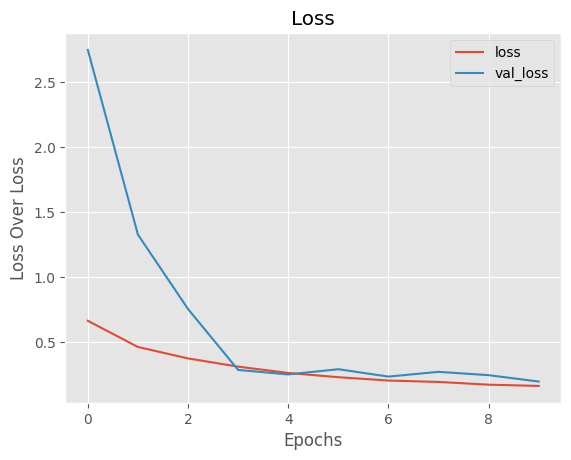

In [35]:
plt.style.use('ggplot')
plt.figure(figsize=(10,5))
result[['loss', 'val_loss']].plot()
plt.xlabel('Epochs')
plt.ylabel('Loss Over Loss')
plt.title('Loss')
plt.show()

<Figure size 1000x500 with 0 Axes>

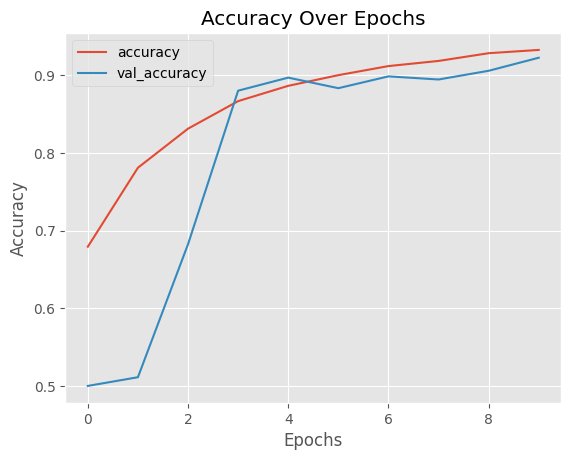

In [36]:
plt.style.use('ggplot')
plt.figure(figsize=(10,5))
result[['accuracy', 'val_accuracy']].plot()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Over Epochs')
plt.show()

# Test Accuracy

In [37]:
evaluation = model.evaluate(test_generator)
print(f'Test Accuracy: {evaluation[1] * 100:.2f}%')

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 789ms/step - accuracy: 0.9206 - loss: 0.2011
Test Accuracy: 92.30%
